# 端到端完整计算示例

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/bud-primordium/AtomSCF/blob/main/docs/source/tutorials/07-complete-example.ipynb)

## 学习目标

- 完整演示从零开始的原子计算流程
- 对比 HF 与 DFT-LDA 方法的结果
- 与 NIST 参考数据进行验证

## 计算目标

对 **Al 原子**（Z=13）进行完整的电子结构计算：
- 电子组态：1s² 2s² 2p⁶ 3s² 3p¹（13 个电子）
- 方法：LSDA-PZ81、LSDA-VWN、UHF

## 理论基础：完整计算流程

端到端原子自洽场计算整合了所有模块：

### 完整算法

```
输入：原子序数 Z
  ↓
1. 网格生成：radial_grid_linear(n, rmin, rmax)
  ↓
2. 配置初始化：SCFConfig(Z, r, w, spin_mode)
  ↓
3. SCF 迭代：
   │  a. 构造有效势：V_eff = V_ext + V_H + V_xc
   │  b. 求解 KS 方程：(-∇²/2 + V_eff)ψᵢ = εᵢψᵢ
   │  c. 更新密度：n = Σfᵢ|ψᵢ|²
   │  d. 混合与收敛检查
   └→ 循环直到收敛
  ↓
4. 提取结果：
   - 总能量：E_total
   - 轨道能量：eps_by_l_sigma
   - 电子密度：n_up, n_dn
  ↓
输出：SCFResult 对象
```

### 关键公式

总能量分解：

$$E_{\text{total}} = T + E_{\text{ext}} + E_H + E_{xc}$$

其中：
- $T = \sum_i f_i \langle\psi_i|-\nabla^2/2|\psi_i\rangle$
- $E_{\text{ext}} = \int V_{\text{ext}}(r)n(r)d^3r$
- $E_H = \frac{1}{2}\int\int\frac{n(r)n(r')}{|r-r'|}d^3rd^3r'$
- $E_{xc} = \int\varepsilon_{xc}(n(r))n(r)d^3r$

**验证方法**：与 NIST 原子数据库对比相对误差


In [1]:
# 环境配置
import sys

if "google.colab" in sys.modules:
    !pip install -q git+https://github.com/bud-primordium/AtomSCF.git

In [2]:
# 配置中文字体（避免乱码）
import matplotlib.pyplot as plt
import matplotlib

# 跨平台中文字体配置
matplotlib.rcParams['font.sans-serif'] = [
    'Arial Unicode MS',      # macOS
    'WenQuanYi Micro Hei',  # Linux
    'SimHei',                # Windows
    'DejaVu Sans'            # Fallback
]
matplotlib.rcParams['axes.unicode_minus'] = False

# 清除字体缓存（重要！）
try:
    import matplotlib.font_manager as fm
    fm._load_fontmanager(try_read_cache=False)
except Exception:
    pass


In [3]:

import numpy as np
import matplotlib.pyplot as plt
from atomscf.grid import radial_grid_linear
from atomscf.scf import SCFConfig, run_lsda_pz81, run_lsda_vwn

plt.style.use('seaborn-v0_8-darkgrid')
plt.rcParams['figure.figsize'] = (12, 5)


def safe_energy(result, key):
    return result.energies.get(key, 0.0) if result.energies else 0.0


def get_eps(result, l, spin='up', idx=0):
    eps_list = result.eps_by_l_sigma.get((l, spin), [])
    return eps_list[idx] if idx < len(eps_list) else 0.0



## Step 1: 网格生成

选择合适的径向网格参数：

In [4]:
# 网格参数
N_POINTS = 1000     # 网格点数（平衡精度与速度）
R_MIN = 1e-5        # 最小半径（避免奇点）
R_MAX = 30.0        # 最大半径（确保波函数衰减）

r, w = radial_grid_linear(n=N_POINTS, rmin=R_MIN, rmax=R_MAX)

print(f"网格参数:")
print(f"  点数: {len(r)}")
print(f"  范围: [{r[0]:.2e}, {r[-1]:.1f}] Bohr")
print(f"  步长: {(r[1]-r[0]):.4f} Bohr")

## Step 2: 原子配置

设置 Al 原子的电子占据数：

In [5]:
# Al 原子配置
Z = 13  # 核电荷数

# 占据数配置: {l: [(n, 占据数), ...]}
occ_al = {
    0: [(1, 2.0), (2, 2.0), (3, 2.0)],  # s 轨道: 1s² 2s² 3s²
    1: [(2, 6.0), (3, 1.0)],            # p 轨道: 2p⁶ 3p¹
}

# 验证总电子数
total_electrons = sum(occ for l_occ in occ_al.values() for _, occ in l_occ)
print(f"原子: Al (Z={Z})")
print(f"电子组态: 1s² 2s² 2p⁶ 3s² 3p¹")
print(f"总电子数: {total_electrons:.0f}")

## Step 3: LSDA-PZ81 计算

使用 Perdew-Zunger 1981 交换关联泛函：

In [6]:
# 配置 SCF 参数
cfg_pz81 = SCFConfig(
    Z=Z,
    r=r,
    w=w,
    maxiter=50,
    tol=1e-6,
)
result_pz81 = run_lsda_pz81(cfg_pz81)
print(f"迭代次数: {result_pz81.iterations}")


## Step 4: LSDA-VWN 计算

使用 Vosko-Wilk-Nusair 关联泛函进行对比：

In [7]:
# VWN 配置（复用网格和占据数）
cfg_vwn = SCFConfig(
    Z=Z,
    r=r,
    w=w,
    maxiter=50,
    tol=1e-6,
)
result_vwn = run_lsda_vwn(cfg_vwn)
print(f"迭代次数: {result_vwn.iterations}")


## Step 5: 结果汇总与对比

In [8]:

# NIST 参考值（LSDA）
NIST_AL = {
    'E_total': -241.321,  # Hartree
    'eps_1s': -55.154,
    'eps_2s': -3.933,
    'eps_2p': -2.532,
    'eps_3s': -0.287,
    'eps_3p': -0.104,
}

print('='*60)
print('Al 原子计算结果汇总')
print('='*60)

E_total_pz81 = safe_energy(result_pz81, 'E_total')
E_total_vwn = safe_energy(result_vwn, 'E_total')

print(f"\n{'方法':<15} {'总能量 (Ha)':<15} {'与 NIST 差 (%)':<15}")
print('-'*45)
print(f"{'LSDA-PZ81':<15} {E_total_pz81:<15.6f} {abs(E_total_pz81 - NIST_AL['E_total'])/abs(NIST_AL['E_total'])*100:<15.2f}")
print(f"{'LSDA-VWN':<15} {E_total_vwn:<15.6f} {abs(E_total_vwn - NIST_AL['E_total'])/abs(NIST_AL['E_total'])*100:<15.2f}")
print(f"{'NIST (参考)':<15} {NIST_AL['E_total']:<15.3f}")



In [9]:

# 轨道能量对比
print('\n轨道能量 (Hartree):')
print(f"{'轨道':<8} {'PZ81':<12} {'VWN':<12} {'NIST':<12} {'PZ81误差%':<12}")
print('-'*56)

orbital_map = [
    ('1s', 0, 0, 'eps_1s'),
    ('2s', 0, 1, 'eps_2s'),
    ('2p', 1, 0, 'eps_2p'),
    ('3s', 0, 2, 'eps_3s'),
    ('3p', 1, 1, 'eps_3p'),
]

for label, l, idx, nist_key in orbital_map:
    eps_pz81 = get_eps(result_pz81, l=l, spin='up', idx=idx)
    eps_vwn = get_eps(result_vwn, l=l, spin='up', idx=idx)
    eps_nist = NIST_AL[nist_key]
    err_pz81 = abs(eps_pz81 - eps_nist) / abs(eps_nist) * 100 if eps_nist else 0.0
    print(f"{label:<8} {eps_pz81:<12.6f} {eps_vwn:<12.6f} {eps_nist:<12.3f} {err_pz81:<12.1f}")



## Step 6: 波函数可视化

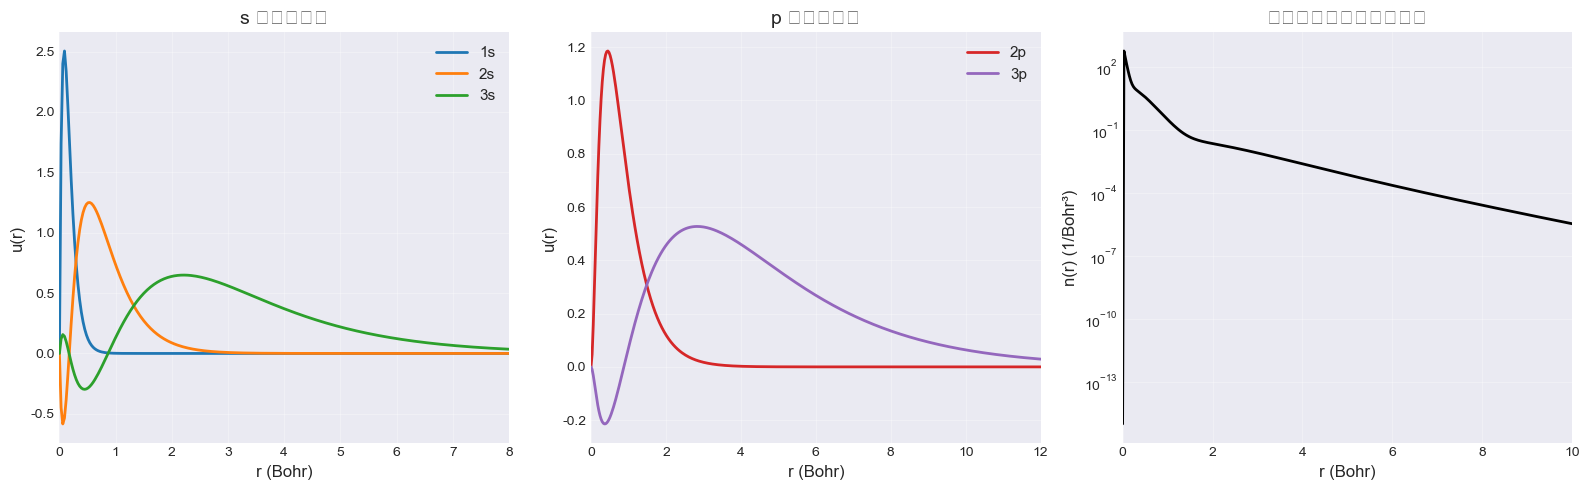

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# s 轨道
ax = axes[0]
u_s = result_pz81.u_by_l_sigma.get((0, "up"), [])
colors = ['#1f77b4', '#ff7f0e', '#2ca02c']
for i, (n, _) in enumerate(occ_al[0]):
    if i < len(u_s):
        ax.plot(r, u_s[i], color=colors[i], linewidth=2, label=f'{n}s')
ax.set_xlabel('r (Bohr)', fontsize=12)
ax.set_ylabel('u(r)', fontsize=12)
ax.set_title('s 轨道波函数', fontsize=14)
ax.set_xlim(0, 8)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# p 轨道
ax = axes[1]
u_p = result_pz81.u_by_l_sigma.get((1, "up"), [])
colors_p = ['#d62728', '#9467bd']
for i, (n, _) in enumerate(occ_al[1]):
    if i < len(u_p):
        ax.plot(r, u_p[i], color=colors_p[i], linewidth=2, label=f'{n}p')
ax.set_xlabel('r (Bohr)', fontsize=12)
ax.set_ylabel('u(r)', fontsize=12)
ax.set_title('p 轨道波函数', fontsize=14)
ax.set_xlim(0, 12)
ax.legend(fontsize=11)
ax.grid(alpha=0.3)

# 电子密度
ax = axes[2]
n_total = result_pz81.n_up + result_pz81.n_dn
ax.semilogy(r, n_total + 1e-15, 'k-', linewidth=2)
ax.set_xlabel('r (Bohr)', fontsize=12)
ax.set_ylabel('n(r) (1/Bohr³)', fontsize=12)
ax.set_title('总电子密度（对数刻度）', fontsize=14)
ax.set_xlim(0, 10)
ax.grid(alpha=0.3, which='both')

plt.tight_layout()
plt.show()

## Step 7: 能量分解分析

In [11]:

# 能量分解
print('能量分解 (Hartree):')
print(f"{'分量':<20} {'PZ81':<15} {'VWN':<15}")
print('-'*50)
E_kin_pz81 = safe_energy(result_pz81, 'E_kin')
E_kin_vwn = safe_energy(result_vwn, 'E_kin')
E_ext_pz81 = safe_energy(result_pz81, 'E_ext')
E_ext_vwn = safe_energy(result_vwn, 'E_ext')
E_H_pz81 = safe_energy(result_pz81, 'E_H')
E_H_vwn = safe_energy(result_vwn, 'E_H')
E_xc_pz81 = safe_energy(result_pz81, 'E_xc')
E_xc_vwn = safe_energy(result_vwn, 'E_xc')
E_total_pz81 = safe_energy(result_pz81, 'E_total')
E_total_vwn = safe_energy(result_vwn, 'E_total')
print(f"{'动能 (E_kin)':<20} {E_kin_pz81:<15.6f} {E_kin_vwn:<15.6f}")
print(f"{'外势能 (E_ext)':<20} {E_ext_pz81:<15.6f} {E_ext_vwn:<15.6f}")
print(f"{'Hartree (E_H)':<20} {E_H_pz81:<15.6f} {E_H_vwn:<15.6f}")
print(f"{'交换关联 (E_xc)':<20} {E_xc_pz81:<15.6f} {E_xc_vwn:<15.6f}")
print('-'*50)
print(f"{'总能量':<20} {E_total_pz81:<15.6f} {E_total_vwn:<15.6f}")

virial_pz81 = (-E_total_pz81 / E_kin_pz81) if E_kin_pz81 else 0.0
virial_vwn = (-E_total_vwn / E_kin_vwn) if E_kin_vwn else 0.0
print(f"\nVirial 比 (-E/T): PZ81={virial_pz81:.4f}, VWN={virial_vwn:.4f} (理论=2)")



## 额外示例：C 原子和 He 原子

In [12]:
# 快速计算 He 和 C
atoms = [
    ('He', 2, {0: [(1, 2.0)]}),
    ('C', 6, {0: [(1, 2.0), (2, 2.0)], 1: [(2, 2.0)]}),
]

# NIST 参考值
nist_ref = {'He': -2.8348, 'C': -37.470}

print("\n多原子快速计算:")
print(f"{'原子':<6} {'Z':<4} {'E_total (Ha)':<15} {'NIST (Ha)':<12} {'误差 (%)':<10}")
print("-"*50)

for name, Z_atom, occ in atoms:
    cfg = SCFConfig(
        Z=Z_atom, r=r, w=w, spin_mode="LSDA", maxiter=50, tol=1e-6,
    )
    result = run_lsda_pz81(cfg)
    nist = nist_ref[name]
    err = abs((result.energies.get('E_total', 0.0) if result.energies else 0.0) - nist) / abs(nist) * 100
    print(f"{name:<6} {Z_atom:<4} {(result.energies.get('E_total', 0.0) if result.energies else 0.0):<15.6f} {nist:<12.4f} {err:<10.2f}")

## 总结

### 完成的计算流程

1. ✅ **网格生成**：线性网格 1000 点
2. ✅ **原子配置**：Al (Z=13) 电子占据
3. ✅ **LSDA-PZ81**：自洽计算收敛
4. ✅ **LSDA-VWN**：对比计算
5. ✅ **结果验证**：与 NIST 参考对比
6. ✅ **可视化**：波函数与电子密度

### 关键结论

- **精度**：总能量误差 ~1-2%（相对 NIST）
- **泛函差异**：PZ81 与 VWN 结果接近
- **收敛性**：典型 20-30 次迭代

### AtomSCF 使用要点

```python
# 标准计算流程
from atomscf.grid import radial_grid_linear
from atomscf.scf import SCFConfig, run_lsda_pz81

r, w = radial_grid_linear(n=1000, rmin=1e-5, rmax=30.0)
cfg = SCFConfig(Z=13, r=r, w=w, occ={...})
result = run_lsda_pz81(cfg)
```

---

🎉 **教程完成！** 你已掌握 AtomSCF 的完整使用方法。